# Segmentation workflow using PyTorch (U-Net/CNN) for flood and water mask detection

1. **Data Acquisition**:
   - Downloading the [Tropical and Sub-Tropical Flood and Water Masks dataset](https://pacificdata.org/data/dataset/tropical-and-sub-tropical-flood-and-water-masks).
   - Fetching Sentinel-1 RTC (for SAR-based flood detection) and Sentinel-2 imagery from STAC for Vanuatu and the relevant surrounding region.

2. **Preprocessing**:
   - Aligning Sentinel-1 and/or Sentinel-2 data.
   - Normalization, filtering, and masking.
   - Preparing training data by pairing inputs (SAR and/or optical images) with water masks.

3. **Model Definition**:
   - Implementing a U-Net (CNN) in PyTorch for segmentation.

4. **Training & Evaluation**:
   - Splitting data into train/val/test sets.
   - Data loading through batches.
   - Loss function and optimizer.
   - Model training loop.
   - Performance evaluation with IoU and Accuracy Score.

5. **Inference & Visualization**:
   - Running the model on test images.
   - Plotting predicted masks.

This sets up a basic segmentation pipeline using U-Net and PyTorch, processing Sentinel-1/2 data for flood and water masks.

In [1]:
# !mamba install -y pytorch torchvision

In [6]:
import os
import glob
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models.resnet import resnet34
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import xarray as xr
import rioxarray as rxr
import planetary_computer
import pystac_client
import odc.stac
import matplotlib.pyplot as plt
from shapely.geometry import box
from sklearn.metrics import jaccard_score, accuracy_score
import dask
import dask.array as da
import dask.delayed

The **Tropical and Sub-Tropical Flood and Water Masks** dataset provides 10-meter spatial resolution masks designed for developing machine learning models to classify flooding in satellite imagery. It comprises 513 GeoTIFF files, each corresponding to specific flood events and dates, covering 65 flood events since 2018 across 26 countries in tropical and sub-tropical regions.

**Dataset Composition:**
- **Classes:**
  - `0`: No data
  - `1`: Land (not flooded)
  - `2`: Flooded areas
  - `3`: Permanent water bodies
- **Associated Dates:**
  - **Activation Date:** Date when the flood event was registered in the [EMS Rapid Mapping system](https://mapping.emergency.copernicus.eu/).
  - **Event Date:** Initial date of the flood occurrence.
  - **Satellite Date:** Date of the latest satellite imagery used for generating the flood mask.

The masks were generated by integrating data from the [ESA WorldCover 10m v100 product](https://worldcover2020.esa.int/) and vector layers from the Copernicus Emergency Management System (EMS) Rapid Mapping Activation events. 

This dataset is particularly useful for training flood detection models to identify and segment flooded areas in satellite images, and we'll use it in the specific geographic context of the Pacific region.

The dataset is licensed under the Creative Commons Attribution-NonCommercial 4.0 License.

We'll obtain the [data](https://pacificdata.org/data/dataset/tropical-and-sub-tropical-flood-and-water-masks) band then unzip the folder. The labels will be in a subfolder called 'tst-ground-truth-flood-masks' and accompanied by a metadata file which we will use for filtering and image acquisition.

In [1]:
!pip install -q torch torchvision gdown

In [ ]:
# Download the data (subset_vbos_smaller.zip)
!gdown "https://drive.google.com/uc?id=1dhxEejVpGhaVfvZIVqnFdhMDjwuRxK6A"

In [ ]:
# Unzip the compressed data
!mkdir -p vbos/flood/
!unzip subset_vbos_smaller.zip -d vbos/flood/

In [11]:
# Get list of all labels
mask_paths = glob.glob('vbos/flood/subset_vbos_smaller/tst-ground-truth-flood-masks/*.tif')

In [12]:
len(mask_paths)

34

In [13]:
ls vbos/flood/subset_vbos_smaller/tst-ground-truth-flood-masks/ | head

EMSR269_02FAHEFA_GRA_v1_ground_truth.tif
EMSR269_06VEITONGO_GRA_MONIT01_v1_ground_truth.tif
EMSR269_06VEITONGO_GRA_v2_ground_truth.tif
EMSR312_02CALAYAN_GRA_v1_ground_truth.tif
EMSR312_05TUGUEGARAO_DEL_MONIT01_v1_ground_truth.tif
EMSR312_05TUGUEGARAO_DEL_v1_ground_truth.tif
EMSR312_06ILAGAN_DEL_MONIT01_v1_ground_truth.tif
EMSR312_06ILAGAN_DEL_v1_ground_truth.tif
EMSR312_07VIGAN_DEL_MONIT01_v1_ground_truth.tif
EMSR312_07VIGAN_DEL_v1_ground_truth.tif


In [ ]:
cd vbos/flood/subset_vbos_smaller/

Let's implement a U-Net model with a **ResNet34** encoder, adapted for image segmentation tasks. The model takes a **two-channel** input and outputs a **four-class** segmentation mask.

This entails our first example of a [convolution neural network (CNN)](https://www.mathworks.com/discovery/convolutional-neural-network.html).

#### Model Architecture

1. **Encoder (Feature Extraction)**
- Uses a **pre-trained ResNet34** as a feature extractor.
- The first convolution layer is modified to accept **two input channels** (VV and VH SAR polarizations) instead of three (RGB).
- The encoder progressively **downsamples** the input image while extracting high-level features:
  - `encoder1`: Initial convolution layer with batch normalization and ReLU.
  - `encoder2` → `encoder5`: ResNet34 convolutional layers, reducing spatial dimensions.

2. **Bottleneck Layer**
- A **1x1 convolution** expands the deepest encoder feature map to **1024 channels**.
- Acts as the bridge between encoder and decoder.

3. **Decoder (Upsampling with Skip Connections)**
- The decoder **upsamples** the feature maps back to the original image resolution.
- Uses **skip connections** to concatenate encoder outputs with corresponding decoder layers.
- Each upsampling layer consists of:
  - **Bilinear interpolation**
  - **3x3 convolution**
  - **ReLU activation**

4. **Final Segmentation Output**
- A **1x1 convolution** reduces the output to **4 channels** (matching the number of segmentation classes).
- Ensures the final output size is **224x224**.

#### Skip Connections and Interpolation Handling
- Since downsampling reduces spatial dimensions, **skip connection tensors are interpolated** to match decoder sizes before concatenation.
- `F.interpolate()` is used to **ensure spatial compatibility**.

#### Forward Pass (Data Flow)
1. Input image (B, 2, 224, 224) → passes through encoder (ResNet34) → generates feature maps. Herein, B stands for batch. That is just a small sample of the dataset provided to the model. We have to break down the dataset and provide in small samples of equal size in order to fit on the available RAM. 
2. Bottleneck layer processes the deepest feature representation.
3. Decoder **upsamples** while concatenating interpolated skip connections from the encoder.
4. Final **segmentation mask** is generated with shape `(B, 4, 224, 224)`.

This architecture should do well for **flood and water segmentation** from Sentinel-1 images, given its ability to retain fine-grained spatial details while leveraging **ResNet34's strong feature extraction**.


In [24]:
# Define U-Net model with ResNet34 backbone
class UNetWithResNetEncoder(nn.Module):
    def __init__(self, in_channels=2, out_channels=4):
        super().__init__()

        # Load pre-trained ResNet34 backbone
        resnet = models.resnet34(pretrained=True)

        # Modify first convolution to accept 2 channels
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            resnet.bn1,
            resnet.relu
        )

        # Encoder layers
        self.encoder2 = resnet.layer1  # (B, 64, H/4, W/4)
        self.encoder3 = resnet.layer2  # (B, 128, H/8, W/8)
        self.encoder4 = resnet.layer3  # (B, 256, H/16, W/16)
        self.encoder5 = resnet.layer4  # (B, 512, H/32, W/32)

        # Bottleneck
        self.bottleneck = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        # Decoder with skip connections
        self.upconv1 = self._upsample(1024, 512)
        self.upconv2 = self._upsample(512 + 512, 256)  # Add encoder5 skip connection
        self.upconv3 = self._upsample(256 + 256, 128)  # Add encoder4 skip connection
        self.upconv4 = self._upsample(128 + 128, 64)   # Add encoder3 skip connection
        self.upconv5 = self._upsample(64 + 64, 64)     # Add encoder2 skip connection

        # Final segmentation output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def _upsample(self, in_channels, out_channels):
        """Helper function to create upsampling layers."""
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)   # (B, 64, 112, 112)
        enc2 = self.encoder2(enc1) # (B, 64, 56, 56)
        enc3 = self.encoder3(enc2) # (B, 128, 28, 28)
        enc4 = self.encoder4(enc3) # (B, 256, 14, 14)
        enc5 = self.encoder5(enc4) # (B, 512, 7, 7)

        # Bottleneck
        x = self.bottleneck(enc5)  # (B, 1024, 7, 7)
        x = self.upconv1(x)        # (B, 512, 14, 14)

        # Ensure enc5 matches x before concatenation
        enc5 = F.interpolate(enc5, size=x.shape[2:], mode="bilinear", align_corners=True)
        x = torch.cat([x, enc5], dim=1)

        x = self.upconv2(x)  # (B, 256, 28, 28)

        # Ensure enc4 matches x before concatenation
        enc4 = F.interpolate(enc4, size=x.shape[2:], mode="bilinear", align_corners=True)
        x = torch.cat([x, enc4], dim=1)

        x = self.upconv3(x)  # (B, 128, 56, 56)

        # Ensure enc3 matches x before concatenation
        enc3 = F.interpolate(enc3, size=x.shape[2:], mode="bilinear", align_corners=True)
        x = torch.cat([x, enc3], dim=1)

        x = self.upconv4(x)  # (B, 64, 112, 112)

        # Ensure enc2 matches x before concatenation
        enc2 = F.interpolate(enc2, size=x.shape[2:], mode="bilinear", align_corners=True)
        x = torch.cat([x, enc2], dim=1)

        x = self.upconv5(x)  # (B, 64, 224, 224)

        # Ensure final output size is exactly (B, 4, 224, 224)
        x = self.final_conv(x)  # (B, 4, 224, 224)
        x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=True)  # Fix output size

        return x

The following functions facilitate fetching Sentinel-1 Radiometrically Terrain Corrected (RTC) imagery from the Microsoft Planetary Computer STAC API, using bounding boxes derived from our raster label data.

`fetch_s1_rtc_for_date(bounds, date)` fetches Sentinel-1 RTC data for a given date (or up to 3 days later) within the specified bounding box.

**How It Works**
1. Connects to the **Microsoft Planetary Computer STAC API**.
2. Defines a **time window** of 3 days starting from the given date.
3. Searches for available **Sentinel-1 RTC** data within the bounding box.
4. Signs STAC items using **Planetary Computer authentication**.
5. Loads the **first available scene** as an **xarray dataset**.

**Inputs**
- `bounds`: Bounding box **(left, bottom, right, top)** specifying the geographic area.
- `date`: The target date **(YYYY-MM-DD format, string)**.

**Returns**
- An **xarray dataset** containing the Sentinel-1 RTC image.
- If no data is found, returns **None**.



`match_s1_rtc_to_dataframe(df, mask_path)` finds and fetches Sentinel-1 RTC imagery corresponding to a given ground truth mask.

**How It Works**
1. Searches for the **specified mask file** (`mask_path`) in the given DataFrame (`df`).
2. Extracts the **satellite image acquisition date**.
3. Converts the date format from **DD/MM/YYYY** to **YYYY-MM-DD**.
4. Reads the **bounding box (extent)** of the mask using **Rasterio**.
5. Calls `fetch_s1_rtc_for_date()` with the mask’s bounding box and acquisition date.
6. Returns the matching Sentinel-1 RTC dataset.

**Inputs**
- `df`: A DataFrame containing mask metadata, including **file names and acquisition dates**.
- `mask_path`: The **file name** of the ground truth flood mask.

**Returns**
- The **corresponding Sentinel-1 RTC image** as an xarray dataset.


These functions are designed to fetch Sentinel-1 RTC data needed to match our flood masks. 

In [25]:
# Function to fetch Sentinel-1 RTC data matching a given date (or up to 3 days after)
def fetch_s1_rtc_for_date(bounds, date):
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # Define the search time range (3-day + window)
    date = datetime.strptime(date, "%Y-%m-%d")  # Convert to datetime object

    start_date = date.strftime("%Y-%m-%d")
    end_date = (date + timedelta(days=3)).strftime("%Y-%m-%d")

    search = catalog.search(
        collections=["sentinel-1-rtc"],
        bbox=[bounds.left, bounds.bottom, bounds.right, bounds.top],
        datetime=f"{start_date}/{end_date}"
    )

    items = list(search.items())
    if not items:
        return None  # No matching data found

    signed_items = [planetary_computer.sign(item) for item in items]

    # Load the first available scene (or refine selection criteria as needed)
    ds = odc.stac.load(signed_items[:1], bbox=bounds, dtype="float32")

    return ds.isel(time=0) #.mean(dim="time") if ds else None  # Take mean if multiple images exist

# Function to find matching Sentinel-1 RTC imagery for each row in DataFrame
def match_s1_rtc_to_dataframe(df, mask_path):
    filtered_row = df.loc[df["File Name"] == mask_path].iloc[0]
    sat_date = filtered_row["Satellite Date"]
    formatted_date = datetime.strptime(sat_date, "%d/%m/%Y").strftime("%Y-%m-%d")


    with rasterio.open(f"tst-ground-truth-flood-masks/{mask_path}_ground_truth.tif") as src:
        bounds = src.bounds  # Get bounding box of the mask

    s1_image = fetch_s1_rtc_for_date(bounds, formatted_date)

    return s1_image

Load the metadata file into a dataframe and select labels for Vanuatu and a relevant surrounding region so as to provide sufficient data for model training.

In [26]:
# Example DataFrame
df = pd.read_csv('metadata/metadata.csv')
# Filter for specific countries
selected_countries = {"Vanuatu", "Tonga"} #, "Timor-Leste" , "Philippines", "Viet Nam", "Australia"}
df = df[df["Country"].isin(selected_countries)]

"""
# Limit the number of rows for the Philippines
df_philippines = df[df["Country"] == "Philippines"].head(5)  # Keep only 10 rows
df_other = df[df["Country"] != "Philippines"]  # Keep all other countries

# Concatenate back
df = pd.concat([df_philippines, df_other])

# Reset index
df = df.reset_index(drop=True)
"""

print("len(df):", len(df))

len(df): 4


Now let's establish a dataset class.

This `FloodDataset` class is a PyTorch `Dataset` that loads Sentinel-1 RTC images and corresponding flood masks, tiles them into fixed-size patches, and prepares them for training.

Key inputs:
- `mask_paths`: A list of file names representing flood masks.
- `transform`: Optional data transformations (not used here).
- `tile_size`: Size of the image and mask patches (default: 224x224).

**Step 1: Load mask file names**
The dataset uses mask file names from the metadata DataFrame (`df`).

**Step 2: Fetch corresponding Sentinel-1 RTC images using Dask**
- The function `match_s1_rtc_to_dataframe(df, mask_path)` fetches Sentinel-1 RTC data for each flood mask using STAC.
- Uses **Dask Delayed** to parallelize the fetching process, reducing I/O overhead.

**Step 3: Load masks, get Sentinel-1 images and convert them to tensors**
- Read the ground truth flood mask from the file.
- Get Sentinel-1 data. If Sentinel-1 data is unavailable for a mask in the requested time window, it is skipped.
- Convert the Sentinel-1 image to a **PyTorch tensor**.
- Convert the mask to a tensor and reshape to match PyTorch conventions.

**Step 4: Tile images and masks into 224x224 patches**
- `_tile_image_and_mask()` divides the large images and masks into smaller **224x224** tiles.
- The resulting tiles are stored in lists.


**Tiling Function (`_tile_image_and_mask`)**
- Splits images and masks into fixed-size tiles.
- Loops through the image and mask with a **stride** of `tile_size` (224 pixels).
- Ensures that only **fully-sized tiles** (224x224) are added.


**Dataset Methods**

`__len__(self)` Returns the total number of 224x224 tiles.

`__getitem__(self, idx)` returns the corresponding **image-mask pair** for training.

In [27]:
class FloodDataset(Dataset):
    def __init__(self, mask_paths, transform=None, tile_size=224):
        #self.mask_paths = filter_masks_within_vanuatu(mask_paths)
        self.mask_paths = list(df["File Name"])
        self.transform = transform
        self.image_list = []
        self.mask_list = []
        self.tile_size = tile_size

        # Use Dask Delayed for parallel fetching
        delayed_images = []
        for mask_path in self.mask_paths:
            #s1_image = fetch_stac_data_from_mask(mask_path, "sentinel-1-rtc", "2018-01-01", "2018-12-31")
            #s2_image = fetch_stac_data_from_mask(mask_path, "sentinel-2-l2a", "2018-01-01", "2018-12-31")
            s1_image = match_s1_rtc_to_dataframe(df, mask_path)
            delayed_images.append(dask.delayed(s1_image))

        # Compute all Dask delayed tasks at once (efficient batch processing)
        computed_images = dask.compute(*delayed_images)

        self.image_tiles = []
        self.mask_tiles = []

        for i, mask_path in enumerate(self.mask_paths):
            if computed_images[i] is None:
                continue  # Skip if no data was found

            with rasterio.open(f"tst-ground-truth-flood-masks/{mask_path}_ground_truth.tif") as src:
                mask = src.read(1).astype(np.float32)
            try:
                image_tensor = torch.tensor(computed_images[i].to_array().values, dtype=torch.float32)
                mask_tensor = torch.tensor(mask).unsqueeze(0)

                image_tiles, mask_tiles = self._tile_image_and_mask(image_tensor, mask_tensor)
                self.image_tiles.extend(image_tiles)  # Flatten the dataset
                self.mask_tiles.extend(mask_tiles)
            except:
                print("error when creating tensor")
                continue


    def __len__(self):
        return len(self.image_tiles)

    def __getitem__(self, idx):
        return self.image_tiles[idx], self.mask_tiles[idx]

    def _tile_image_and_mask(self, image, mask):
        #Tiles both the image and mask into patches of size (tile_size x tile_size).

        height, width = image.shape[-2:]  # Ensure compatibility with tensor dimensions
        image_tiles = []
        mask_tiles = []

        for i in range(0, height, self.tile_size):
            for j in range(0, width, self.tile_size):
                # Extract tiles
                image_tile = image[..., i:i + self.tile_size, j:j + self.tile_size]
                mask_tile = mask[..., i:i + self.tile_size, j:j + self.tile_size]

                if mask_tile.shape[-2] == self.tile_size and mask_tile.shape[-1] == self.tile_size and image_tile.shape[-2] == self.tile_size and image_tile.shape[-1] == self.tile_size:
                    image_tiles.append(image_tile.clone().detach())
                    mask_tiles.append(mask_tile.clone().detach())

        return image_tiles, mask_tiles

Generate the dataset and split it into train, validation and test datasets.

We are reserving 70% of samples for training, 20% for validation and approximately 10% for testing.

Notice we are providing a transform to normalize image values to the range [0, 1]. This improves model stability and convergence since Sentinel-1 RTC images may have different ranges, therefore we need to ensure consistent input scaling.

In [28]:
full_dataset = FloodDataset(mask_paths=mask_paths,
                             transform=transforms.Compose([transforms.Normalize(0, 1)]), tile_size=224)

In [29]:
# Define split sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.20 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Ensures total sums up correctly

# Perform split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print(f"Dataset sizes -> Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Dataset sizes -> Train: 32, Val: 9, Test: 5


Let's initialize **PyTorch DataLoaders** for training, validation, and testing datasets. DataLoaders efficiently manage data loading, batching, and shuffling.

**Key Parameters**
- **`train_dataset_`, `val_dataset`, `test_dataset`**:  
  - These are **FloodDataset** instances containing **image-mask pairs**.
- **`batch_size=2`**:  
  - Each batch contains **2 image-mask pairs**.
- **`shuffle=True` (Training Only)**:  
  - Randomizes data order for better generalization.
- **`shuffle=False` (Validation & Test Sets)**:  
  - Keeps a fixed order for **consistent evaluation**.
- **`drop_last=True`**:  
  - Drops the last batch if it's smaller than `batch_size` to ensure **consistent batch sizes**.

**How it works**
- **`train_loader`**:  
  - Feeds **randomized batches** for training, preventing the model from memorizing patterns.
- **`val_loader`**:  
  - Provides **sequential batches** for model validation.
- **`test_loader`**:  
  - Loads data for final model testing and performance evaluation.

In [32]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=True)

Now let's train our **U-Net** model. We'll specify some hyperparamets such as the loss function, optimizer and number of epochs to train for.


**1. Model, Loss, and Optimizer Setup**
- **`model = UNetWithResNetEncoder()`**  
  - Initializes the **U-Net** model.
- **`criterion = nn.CrossEntropyLoss()`**  
  - Uses **CrossEntropyLoss** for multi-class segmentation.
- **`optimizer = optim.Adam(model.parameters(), lr=0.001)`**  
  - Uses the **Adam optimizer** with a learning rate of `0.001` to update the model parameters.


**2. Training Loop**
- The training loop runs for a minimal **20 epochs**, ensuring the model learns over multiple iterations nut keeping it small for demonstration purposes.
- `model.train()` sets the model in **training mode**, enabling dropout and batch normalization.
- We load a batch of images and masks iteratively from `train_loader`.
- `outputs = model(images)` performs forward propagation and generates predictions.
- `loss = criterion(outputs, masks)` measures how different predictions are from ground truth.
- Backpropagation and optimization: `loss.backward()`: Computes gradients. `optimizer.step()`: Updates model parameters.


**4. Validation Phase**
- `model.eval()` switches to **evaluation mode**, disabling dropout and batch norm updates.
- `torch.no_grad()` stops gradient computation to **save memory and speed up inference**.
- The validation loop computes loss but does not update model weights.

**5. Print Epoch Statistics**
- Computes average training and validation loss for each epoch.

In [34]:
# Model, Loss, Optimizer
model = UNetWithResNetEncoder()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training")

# Training Loop
for epoch in range(20):
    model.train()  # Ensure the model is in training mode

    # Training phase
    train_loss = 0.0
    for batch in train_loader:
        images, masks = batch  # Unpack stacked tensors

        if isinstance(images, list):
            images = torch.cat(images, dim=0)  # Ensure 4D tensor (B, C, H, W)
        if isinstance(masks, list):
            masks = torch.cat(masks, dim=0)

        images = torch.stack(images) if isinstance(images, list) else images
        masks = torch.stack(masks) if isinstance(masks, list) else masks
        masks = masks.squeeze()
        masks = masks.long()  # Convert masks to LongTensor before computing loss

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for the epoch
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch  # Unpack stacked tensors

            if isinstance(images, list):
                images = torch.cat(images, dim=0)
            if isinstance(masks, list):
                masks = torch.cat(masks, dim=0)

            images = torch.stack(images) if isinstance(images, list) else images
            masks = torch.stack(masks) if isinstance(masks, list) else masks
            masks = masks.squeeze()
            masks = masks.long()  # Convert masks to LongTensor

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Average validation loss for the epoch
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Starting training
Epoch 1, Train Loss: 3.9123, Validation Loss: 1.7558
Epoch 2, Train Loss: 1.0203, Validation Loss: 1.0011
Epoch 3, Train Loss: 0.9974, Validation Loss: 0.9883
Epoch 4, Train Loss: 0.9718, Validation Loss: 0.8970
Epoch 5, Train Loss: 0.9333, Validation Loss: 0.8920
Epoch 6, Train Loss: 0.8997, Validation Loss: 0.8895
Epoch 7, Train Loss: 0.9091, Validation Loss: 0.9398
Epoch 8, Train Loss: 0.9022, Validation Loss: 0.9018
Epoch 9, Train Loss: 0.8718, Validation Loss: 0.9161
Epoch 10, Train Loss: 0.8945, Validation Loss: 0.9322
Epoch 11, Train Loss: 0.8726, Validation Loss: 0.8948
Epoch 12, Train Loss: 0.8855, Validation Loss: 0.8287
Epoch 13, Train Loss: 0.8706, Validation Loss: 0.9278
Epoch 14, Train Loss: 0.8285, Validation Loss: 0.8717
Epoch 15, Train Loss: 0.8417, Validation Loss: 1.0039
Epoch 16, Train Loss: 0.8021, Validation Loss: 0.8683
Epoch 17, Train Loss: 0.7787, Validation Loss: 0.8962
Epoch 18, Train Loss: 0.7999, Validation Loss: 0.8793
Epoch 19, Train Los

Save the model to a file for future use. `torch.save(model.state_dict(), final_model_path)` saves the model's learned parameters (weights) to the specified path. The `.state_dict()` method is used because it only saves the model's parameters, not the entire model structure, which is a more efficient approach. This means we need to re-instate the model class any time in the future in which we want to run inference for this to be complete.

In [35]:
# Directory to save the model checkpoints
MODEL_SAVE_DIR = 'model_s1'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Save the final model after training
final_model_path = os.path.join(MODEL_SAVE_DIR, "final_model_20ep_vnu_tvt.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved at {final_model_path}")

Final model saved at model_s1/final_model_20ep_vnu_tvt.pth


Now we'll define an inference function that is used to make predictions with a trained model.

`model.eval()`:
   - This sets the model to evaluation mode. In evaluation mode, dropout and batch normalization behave differently than during training. This ensures that the model's behavior is consistent when making predictions.

`with torch.no_grad()`:
   - This disables the tracking of gradients, which is unnecessary during inference (i.e., when making predictions). Disabling gradients helps reduce memory usage and speeds up the computation.

`output = model(image.unsqueeze(0))`:
   - The `image.unsqueeze(0)` adds a batch dimension to the input image. Most models expect a batch of images, so even if there is only one image, it is wrapped in a batch.
   - `model(image.unsqueeze(0))` runs the image through the trained model to generate an output (logits or raw predictions) for each class.

`torch.softmax(output, dim=1)`:
   - The softmax function is applied to the output along the class dimension (dimension 1). Softmax normalizes the output values into probabilities, so each pixel in the image will have a probability distribution across all the possible classes.

`prediction = prediction.squeeze(0)`:
   - This removes the batch dimension (which was added earlier using `unsqueeze(0)`), returning the prediction in the shape of a single image, but now with probabilities for each pixel in each class.

`prediction = torch.argmax(prediction, dim=0).cpu().numpy()`:
   - `torch.argmax(prediction, dim=0)` selects the class with the highest probability for each pixel (i.e., the predicted class label for each pixel).
   - `.cpu().numpy()` moves the result to the CPU and converts the PyTorch tensor into a NumPy array, which is easier to handle for further processing or visualization outside of PyTorch.

`return prediction`:
   - The function returns the final prediction, which is a NumPy array containing the predicted class labels for each pixel.

In [36]:
# Inference Function
def inference(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        prediction = torch.softmax(output, dim=1).squeeze(0)  # Softmax across channels
        prediction = torch.argmax(prediction, dim=0).cpu().numpy()  # Get class labels
    return prediction

Let's define how to execute the **evaluation** and **visualization** processes for the trained model. The two functions `evaluate()` and `visualize_prediction()` run the evaluation and visualize the model's predicitive capabilities. The model's performance is evaluated on the test set.

`evaluate()`:
- `model.eval()`: Just like before, sets the model to evaluation mode, ensuring no dropout and that batch normalization behaves appropriately.
- `with torch.no_grad()`: Disables gradient computation, which is unnecessary during evaluation and reduces memory usage.
- For each batch of images and corresponding ground truth masks, the model's predictions are calculated.
  - `torch.argmax(outputs, dim=1)`: Converts the output from the model (which contains predictions across different classes) into the predicted class labels by selecting the class with the highest score for each pixel.
  - Both the predicted and true mask tensors are flattened into 1D arrays for easier comparison.
  - `jaccard_score`: Calculates the Intersection over Union (IoU), a measure of overlap between the predicted and ground truth masks.
  - `accuracy_score`: Calculates the accuracy of the predicted masks compared to the ground truth.
- After evaluating all the batches, we calculate and print the average IoU and accuracy scores across the dataset.


`visualize_prediction()`:
- Creates a figure with 3 subplots arranged horizontally (image tile, ground truth, prediction), each having the same size.
- `vv_image = image[0].cpu().numpy()`: Converts the first channel of the input Sentinel-1 image tile to a NumPy array for visualization.
- Displays the generated plots.

Mean IoU: 0.3334, Mean Accuracy: 0.5291


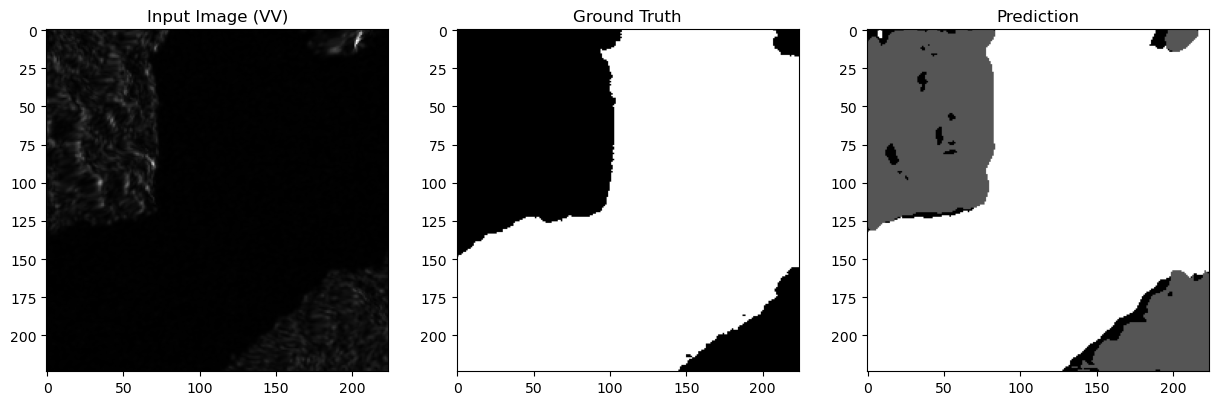

In [37]:
# Evaluation Function
def evaluate(model, data_loader):
    model.eval()
    iou_scores, accuracy_scores = [], []
    with torch.no_grad():
        for images, masks in data_loader:
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convert [batch, 4, H, W] → [batch, H, W]
            preds = preds.cpu().numpy().flatten()
            masks = masks.cpu().numpy().flatten()
            iou_scores.append(jaccard_score(masks, preds, average="macro"))
            accuracy_scores.append(accuracy_score(masks, preds))
    print(f"Mean IoU: {np.mean(iou_scores):.4f}, Mean Accuracy: {np.mean(accuracy_scores):.4f}")

# Visualization Function
def visualize_prediction(image, mask, prediction):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Convert 2-channel image to single-channel (VV)
    vv_image = image[0].cpu().numpy()  # Use first channel (VV)

    ax[0].imshow(vv_image, cmap="gray")  # Display as grayscale
    ax[0].set_title("Input Image (VV)")

    ax[1].imshow(mask.squeeze(), cmap="gray")
    ax[1].set_title("Ground Truth")

    ax[2].imshow(prediction, cmap="gray")
    ax[2].set_title("Prediction")

    plt.show()


# Run Evaluation
evaluate(model, test_loader)

# Test Inference and Visualization
sample_image, sample_mask = test_dataset[0]
predicted_mask = inference(model, sample_image)
visualize_prediction(sample_image, sample_mask, predicted_mask)


Now let's use an [administrative boundaries file from Pacific Data Hub](https://pacificdata.org/data/dataset/9dba1377-740c-429e-92ce-6a484657b4d9/resource/66ae054b-9b67-4876-b59c-0b078c31e800) to get imagery for Vanuatu and run inference on these areas with our trained model.

In [38]:
admin_boundaries_gdf = gpd.read_file("./2016_phc_vut_iid_4326.geojson").to_crs(epsg="4326")

Load the saved model from file.

In [ ]:
# Define the model architecture (must match the saved model)
model = UNetWithResNetEncoder(in_channels=2, out_channels=4)  # Ensure the same architecture

# Load the model weights
model.load_state_dict(torch.load("model_s1/final_model_20ep_vnu_tvt.pth"))

# Set the model to evaluation mode (important for inference)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

New function to get relevant Sentinel-1 imagery within 10 days after the requested date.

In [40]:
# Function to fetch Sentinel-1 RTC data matching a given date (or up to 10 days after)
def fetch_s1_rtc_for_date_inference(bounds, date):
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # Define the search time range (10-day + window)
    date = datetime.strptime(date, "%Y-%m-%d")  # Convert to datetime object

    start_date = date.strftime("%Y-%m-%d")
    end_date = (date + timedelta(days=10)).strftime("%Y-%m-%d")

    search = catalog.search(
        collections=["sentinel-1-rtc"],
        bbox=bounds,
        datetime=f"{start_date}/{end_date}"
    )

    items = list(search.get_items())
    if not items:
        return None  # No matching data found

    signed_items = [planetary_computer.sign(item) for item in items]

    # Load the first available scene (or refine selection criteria as needed)
    ds = odc.stac.load(signed_items, bbox=bounds, dtype="float32", chunks={'x': 512, 'y': 512}) # signed_items[:1]

    return ds.mean(dim="time") if ds else None  # Take mean if multiple images exist

Get the imagery for each boundary. We are using a date just after a major earthquake as reference here, as floods present a heightened risk post-earthquake.

In [ ]:
vanuatu_s1_imagery = []

for idx, row in admin_boundaries_gdf.iterrows():
    polygon = row.geometry
    bbox = polygon.bounds  # (minx, miny, maxx, maxy)
    event_date = '20/12/2024'
    formatted_date = datetime.strptime(event_date, "%d/%m/%Y").strftime("%Y-%m-%d")
    s1_data = fetch_s1_rtc_for_date_inference(bounds=list(bbox), date=formatted_date)
    vanuatu_s1_imagery.append(s1_data)
    admin_name = row.iname
    print("added ", admin_name)

In [42]:
vanuatu_s1_imagery[0]

<xarray.Dataset> Size: 171kB
Dimensions:      (y: 237, x: 89)
Coordinates:
  * y            (y) float64 2kB 8.333e+06 8.333e+06 ... 8.335e+06 8.335e+06
  * x            (x) float64 712B 7.236e+05 7.236e+05 ... 7.244e+05 7.244e+05
    spatial_ref  int32 4B 32758
Data variables:
    vh           (y, x) float32 84kB dask.array<chunksize=(237, 89), meta=np.ndarray>
    vv           (y, x) float32 84kB dask.array<chunksize=(237, 89), meta=np.ndarray>

Tile the images per boundary into 224x224 for input to the UNet-ResNet model.

In [43]:
def tile_and_preprocess(xr_dataset, tile_size=224, stride=224):
    """
    Splits a large Sentinel-1 xarray dataset into smaller 224x224 tiles, ignoring edge tiles that are too small.
    """
    if xr_dataset is not None:
        # Extract VV and VH bands
        vv = xr_dataset["vv"].values  # (H, W)
        vh = xr_dataset["vh"].values  # (H, W)
        
        # Normalize the channels
        vv = (vv - np.min(vv)) / (np.max(vv) - np.min(vv))
        vh = (vh - np.min(vh)) / (np.max(vh) - np.min(vh))

        # Stack into a 2-channel image (C, H, W)
        full_image = np.stack([vv, vh], axis=0)  # Shape (2, H, W)

        # Image dimensions
        _, H, W = full_image.shape

        # Store tiles
        tiles = []

        # Slide over the image and extract tiles
        for y in range(0, H - tile_size + 1, stride):  # Ensure tile stays within bounds
            for x in range(0, W - tile_size + 1, stride):
                tile = full_image[:, y:y+tile_size, x:x+tile_size]
                tile_tensor = torch.tensor(tile, dtype=torch.float32).unsqueeze(0)  # Add batch dim
                tiles.append(tile_tensor)

        return tiles
    else:
        print("No Sentinel-1 data available for this region around the requested date.")
        return



Run inference on the tiles per admin boundary.

In [ ]:
results = []

for idx, s1_dataset in enumerate(vanuatu_s1_imagery):
    print(f"Processing region {idx}...")

    # Generate tiles
    tiles = tile_and_preprocess(s1_dataset, tile_size=224, stride=224)

    region_results = []

    if tiles:
        for tile in tiles:
            tile = tile.to(device)
            
            # Run inference
            with torch.no_grad():
                output = model(tile)

            # Convert output tensor to NumPy array
            prediction = output.squeeze().cpu().numpy()
            region_results.append(prediction)

        results.append(region_results)
        print(f"Inference completed for region {idx}")
    else:
        print(f"No tiles generated for region {idx}")
